In [15]:
import torch
import re
import string
import unidecode
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
# import gensim.downloader as api
# from pycontractions import Contractions
from word2number import w2n
import json
import spacy
from transformers import AutoTokenizer
from datasets import load_dataset
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import nltk
import string
import random
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

Text Processing:

Text normalization (e.g., lowercasing, punctuation removal)
Tokenization and lemmatization
Handling of slang and abbreviations specific to mental health discussions

In [2]:
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
dataset = load_dataset("Amod/mental_health_counseling_conversations")
dataset

DatasetDict({
    train: Dataset({
        features: ['Context', 'Response'],
        num_rows: 3512
    })
})

In [5]:
raw_train = dataset["train"]
raw_train

Dataset({
    features: ['Context', 'Response'],
    num_rows: 3512
})

In [6]:
print(raw_train[0]['Context'] + '\n')
print(raw_train[0]['Response'] + '\n')
print(raw_train.features)

I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.
   I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.
   How can I change my feeling of being worthless to everyone?

If everyone thinks you're worthless, then maybe you need to find new people to hang out with.Seriously, the social context in which a person lives is a big influence in self-esteem.Otherwise, you can go round and round trying to understand why you're not worthless, then go back to the same crowd and be knocked down again.There are many inspirational messages you can find in social media.  Maybe read some of the ones which state that no person is worthless, and that everyone has a good purpose to their life.Also, since our culture is so saturated with the belief that if someone doesn't feel good about themselves that this is somehow terrible.Bad feelings are part

In [7]:
train_df = dataset["train"].to_pandas()
train_df.head()

,Context,Response
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb..."
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see..."
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...


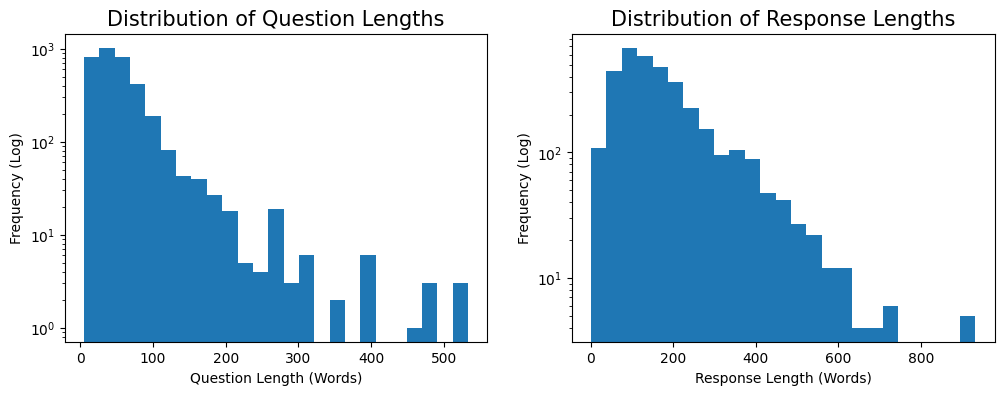

In [14]:
figs, axs = plt.subplots(1,2,figsize=(12,4))

# average length of question
train_df['questionLength'] = train_df['Context'].apply(lambda x: len(x.split(" ")))
train_df['questionLength'].astype(int).plot.hist(bins=25, ax=axs[0], logy=True)
axs[0].set_xlabel("Question Length (Words)", fontsize=10)
axs[0].set_ylabel("Frequency (Log)", fontsize=10)
axs[0].set_title("Distribution of Question Lengths", fontsize=15)

# average length of question
train_df['responseLength'] = train_df['Response'].apply(lambda x: len(x.split(" ")))
train_df['responseLength'].astype(int).plot.hist(bins=25, ax=axs[1], logy=True)
axs[1].set_xlabel("Response Length (Words)", fontsize=10)
axs[1].set_ylabel("Frequency (Log)", fontsize=10)
axs[1].set_title("Distribution of Response Lengths", fontsize=15)

plt.show()


In [10]:
# Used to randomly select items to manually label
# indices_to_display = train_df.sample(n=30).index

# # Display the contents of the selected rows from the 'Context' column
# selected_rows = train_df.loc[indices_to_display, 'Context']
# print(selected_rows)

# file_path = 'randomly_selected_rows.txt'

# # Write the selected rows to the text file
# with open(file_path, 'w') as file:
#     for row in selected_rows:
#         file.write(row + '\n')

# print(f"Selected rows have been written to '{file_path}'.")

2469    It's been almost a year since my ex-boyfriend ...
2394    I have lately been having lots of anxiety and ...
1238     I love him so much, and I don't know what to do.
3489    I know that I need to get past my feelings for...
2431    From the moment I wake up, I hear what I think...
2037    How does a counselor decide when to end counse...
2305    I am currently suffering from erectile dysfunc...
1798    How does a counselor decide when to end counse...
2630    I am married, but I had sex with my friend. I ...
1318    My boyfriend and I recently broke up. One week...
424     I recently broke up with my boyfriend After be...
1920    How do you know you have the right therapist f...
20      I'm going through some things with my feelings...
1539    I'm having relationship problems and I want to...
736     I feel like I hate myself physically and emoti...
420     I just took a job that requires me to travel f...
1882    I'm currently struggling with diagnosed depres...
1766    I was 

In [12]:
contractions_dict = {
    "ain't": "is not", "aren't": "are not", "can't": "cannot", "couldn't": "could not",
    "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
    "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will",
    "he's": "he is", "i'm": "i am", "I'd": "I would", "I'll": "I will", "I'm": "I am", "I've": "I have",
    "isn't": "is not", "it'd": "it would", "it'll": "it will", "it's": "it is",
    "let's": "let us", "mightn't": "might not", "mustn't": "must not", "shan't": "shall not",
    "she'd": "she would", "she'll": "she will", "she's": "she is", "shouldn't": "should not",
    "that's": "that is", "there's": "there is", "they'd": "they would", "they'll": "they will",
    "they're": "they are", "they've": "they have", "we'd": "we would", "we're": "we are",
    "we've": "we have", "weren't": "were not", "what'll": "what will", "what's": "what is",
    "who's": "who is", "won't": "will not", "wouldn't": "would not", "you'd": "you would",
    "you'll": "you will", "you're": "you are", "you've": "you have"
}

def expand_contractions(text, contractions_dict):
    pattern = re.compile(r'\b(' + '|'.join(contractions_dict.keys()) + r')\b')
    return pattern.sub(lambda x: contractions_dict[x.group()], text)

train_df['Context'] = train_df['Context'].apply(lambda x: expand_contractions(x, contractions_dict))
train_df['Response'] = train_df['Response'].apply(lambda x: expand_contractions(x, contractions_dict))
train_df.head()

,Context,Response
0,I am going through some things with my feeling...,"If everyone thinks you are worthless, then may..."
1,I am going through some things with my feeling...,"Hello, and thank you for your question and see..."
2,I am going through some things with my feeling...,First thing I would suggest is getting the sle...
3,I am going through some things with my feeling...,Therapy is essential for those that are feelin...
4,I am going through some things with my feeling...,I first want to let you know that you are not ...


In [13]:
df = train_df
# convert text to lowercase
df['Context'] = df['Context'].str.lower()
df['Response'] = df['Response'].str.lower()
df.head()

,Context,Response
0,i am going through some things with my feeling...,"if everyone thinks you are worthless, then may..."
1,i am going through some things with my feeling...,"hello, and thank you for your question and see..."
2,i am going through some things with my feeling...,first thing i would suggest is getting the sle...
3,i am going through some things with my feeling...,therapy is essential for those that are feelin...
4,i am going through some things with my feeling...,i first want to let you know that you are not ...


In [40]:
# Strip punctuation
df['Context'] = df['Context'].str.translate(str.maketrans('', '', string.punctuation))
df['Response'] = df['Response'].str.translate(str.maketrans('', '', string.punctuation))

# tokenize text
df['Context'] = df['Context'].apply(word_tokenize)
df['Response'] = df['Response'].apply(word_tokenize)



In [41]:
# remove non-alphabetic characters
df['Context'] = df['Context'].apply(lambda x: [word for word in x if word.isalpha()])
df['Response'] = df['Response'].apply(lambda x: [word for word in x if word.isalpha()])

In [42]:
# remove stop-words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
df['Context'] = df['Context'].apply(lambda x: [word for word in x if word not in stop_words])
df['Response'] = df['Response'].apply(lambda x: [word for word in x if word not in stop_words])

In [43]:
# lemmatization
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
df['Context'] = df['Context'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
df['Response'] = df['Response'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [44]:
df.dropna(inplace=True)

In [45]:
df.head()

,Context,Response,context_str,intent
4,"[Im, going, thing, feeling, I, barely, sleep, ...","[I, first, want, let, know, alone, feeling, al...",I ' m g o i n g t h r o u g h s o m e ...,Coping with depression or sadness
61,"[I, many, issue, address, I, history, sexual, ...","[Thank, sharing, history, You, many, issue, ad...",I h a v e s o m a n y i s s u e s t ...,Managing symptoms of a mental health condition
88,"[I, suffer, adult, ADHD, anxiety, disorder, de...","[I, would, check, agency, offer, affordable, c...",I s u f f e r f r o m a d u l t A D H ...,Managing symptoms of a mental health condition
337,"[When, Im, large, crowd, I, get, angry, I, can...","[Its, totally, normal, feel, overwhelmed, unco...",W h e n I ' m i n l a r g e c r o w d ...,Managing social phobia
456,"[My, son, diagnosed, autism, year, ago, I, sto...","[Id, wonder, first, still, home, neighborhood,...",M y s o n w a s d i a g n o s e d w i ...,Managing social phobia


Intent Classification:

Development of a classification model to discern user intents such as seeking advice, asking for references, or needing urgent help.
Training the model using supervised learning techniques with labeled examples from the datasets.

In [38]:
df['intent'] = None

# defining small sample of intentions
# [   4, 1024, 3170, 2895, 1486, 2879,   88, 1513, 2166, 1171, 1530,  891,
    #    1438, 1234,  745, 2989, 2074,  456,  337, 3073, 2873, 1564,  735, 3469,
    #    1546, 2793,   61, 2772, 2462, 3063]
df.at[4, 'intent'] = 'Coping with depression or sadness'
df.at[1024, 'intent'] = 'Managing anger or frustration'
df.at[3170, 'intent'] = 'Exploring spiritual or existential concerns'
df.at[2895, 'intent'] = 'Addressing relationship issues or conflicts'
df.at[1486, 'intent'] = 'Addressing relationship issues or conflicts'
df.at[2879, 'intent'] = 'Exploring spiritual or existential concerns'
df.at[88, 'intent'] = 'Managing symptoms of a mental health condition'
df.at[1513, 'intent'] = 'Addressing relationship issues or conflicts'
df.at[2166, 'intent'] = 'Coping with depression or sadness'
df.at[1171, 'intent'] = 'Exploring identity or self-discovery'
df.at[1530, 'intent'] = 'Addressing relationship issues or conflicts'
df.at[891, 'intent'] = 'Addressing work-related stress or burnout'
df.at[1438, 'intent'] = 'Addressing relationship issues or conflicts'
df.at[1234, 'intent'] = 'Addressing relationship issues or conflicts'
df.at[745, 'intent'] = 'Improving self-esteem or self-confidence'
df.at[2989, 'intent'] = 'Managing symptoms of a mental health condition'
df.at[2074, 'intent'] = 'Managing symptoms of anxiety'
df.at[456, 'intent'] = 'Managing social phobia'
df.at[337, 'intent'] = 'Managing social phobia'
df.at[3073, 'intent'] = 'Managing symptoms of anxiety'
df.at[2873, 'intent'] = 'Exploring spiritual or existential concerns'
df.at[1564, 'intent'] = 'Addressing relationship issues or conflicts'
df.at[735, 'intent'] = 'Improving self-esteem or self-confidence'
df.at[3469, 'intent'] = 'Seeking help for fears'
df.at[1546, 'intent'] = 'Addressing relationship issues or conflicts'
df.at[2793, 'intent'] = 'Coping with depression or sadness'
df.at[61, 'intent'] = 'Managing symptoms of a mental health condition'
df.at[2772, 'intent'] = 'Dealing with grief or loss'
df.at[2462, 'intent'] = 'Managing anger or frustration'
df.at[3063, 'intent'] = 'Addressing relationship issues or conflicts'

In [46]:
df['context_str'] = df['Context'].apply(lambda x: ' '.join(x))

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['context_str']).toarray()

# Define the target variable
y = df['intent']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Start with training a multiclass naive bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Predict the intents for the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Predict the intents for the entire dataset
df['predicted_intent'] = classifier.predict(X)

# Display the DataFrame with the predicted intents
print(df[['context_str', 'intent', 'predicted_intent']])


                                             precision    recall  f1-score   support

Addressing relationship issues or conflicts       0.17      1.00      0.29         1
       Exploring identity or self-discovery       0.00      0.00      0.00         1
Exploring spiritual or existential concerns       0.00      0.00      0.00         1
              Managing anger or frustration       0.00      0.00      0.00         1
               Managing symptoms of anxiety       0.00      0.00      0.00         2

                                   accuracy                           0.17         6
                                  macro avg       0.03      0.20      0.06         6
                               weighted avg       0.03      0.17      0.05         6

Accuracy: 0.16666666666666666
                                            context_str  \
4     Im going thing feeling I barely sleep I nothin...   
61    I many issue address I history sexual abuse I ...   
88    I suffer adult ADHD

c:\Users\tkhan0770\Downloads\NLP Final Proj\env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tkhan0770\Downloads\NLP Final Proj\env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tkhan0770\Downloads\NLP Final Proj\env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [49]:
# Create the context string from the list of words
df['context_str'] = df['Context'].apply(lambda x: ' '.join(x))

# Filter out rows with None in the intent column
df_filtered = df[df['intent'].notna()]

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df_filtered['context_str']).toarray()
y = df_filtered['intent']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classifier (e.g., Naive Bayes)
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Predict the intents for the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Predict the intents for the entire dataset
X_full = vectorizer.transform(df['context_str']).toarray()
df['predicted_intent'] = classifier.predict(X_full)

# Display the DataFrame with the predicted intents
print(df[['context_str', 'intent', 'predicted_intent']])

                                             precision    recall  f1-score   support

Addressing relationship issues or conflicts       0.17      1.00      0.29         1
       Exploring identity or self-discovery       0.00      0.00      0.00         1
Exploring spiritual or existential concerns       0.00      0.00      0.00         1
              Managing anger or frustration       0.00      0.00      0.00         1
               Managing symptoms of anxiety       0.00      0.00      0.00         2

                                   accuracy                           0.17         6
                                  macro avg       0.03      0.20      0.06         6
                               weighted avg       0.03      0.17      0.05         6

Accuracy: 0.16666666666666666
                                            context_str  \
4     Im going thing feeling I barely sleep I nothin...   
61    I many issue address I history sexual abuse I ...   
88    I suffer adult ADHD

c:\Users\tkhan0770\Downloads\NLP Final Proj\env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tkhan0770\Downloads\NLP Final Proj\env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tkhan0770\Downloads\NLP Final Proj\env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [50]:
df['context_str'] = df['Context'].apply(lambda x: ' '.join(x))

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['context_str']).toarray()

y = df['intent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate different classifiers

# K-Nearest Neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)
print("K-Nearest Neighbors Classification Report")
print(classification_report(y_test, y_pred_knn))
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))

# Support Vector Machine
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)
print("Support Vector Machine Classification Report")
print(classification_report(y_test, y_pred_svm))
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
print("Random Forest Classification Report")
print(classification_report(y_test, y_pred_rf))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

# K-Means Clustering
kmeans = KMeans(n_clusters=len(df['intent'].unique()), random_state=42)
kmeans.fit(X)
df['cluster'] = kmeans.labels_
print("K-Means Clustering")
print(df[['context_str', 'intent', 'cluster']].head())

df['predicted_intent_rf'] = svm_classifier.predict(X)

# Display the DataFrame with the predicted intents
print(df[['context_str', 'intent', 'predicted_intent_rf']])


Support Vector Machine Classification Report
                                             precision    recall  f1-score   support

Addressing relationship issues or conflicts       0.20      1.00      0.33         1
       Exploring identity or self-discovery       0.00      0.00      0.00         1
Exploring spiritual or existential concerns       1.00      1.00      1.00         1
              Managing anger or frustration       0.00      0.00      0.00         1
               Managing symptoms of anxiety       0.00      0.00      0.00         2

                                   accuracy                           0.33         6
                                  macro avg       0.24      0.40      0.27         6
                               weighted avg       0.20      0.33      0.22         6

SVM Accuracy: 0.3333333333333333
                                            context_str  \
4     Im going thing feeling I barely sleep I nothin...   
61    I many issue address I history

c:\Users\tkhan0770\Downloads\NLP Final Proj\env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tkhan0770\Downloads\NLP Final Proj\env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tkhan0770\Downloads\NLP Final Proj\env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [29]:
# Predict the intents for the entire dataset
X_full = vectorizer.transform(df['context_str']).toarray()

# Create a mask to identify rows with None intent
mask_none = df['intent'].isna()

# Predict the intents for rows with None intent
df.loc[mask_none, 'intent'] = classifier.predict(X_full[mask_none])

# Display the DataFrame with the updated intents
print(df[['context_str', 'intent']])

                                               context_str  \
cluster                                                      
2        going thing feeling barely sleep nothing think...   
2        going thing feeling barely sleep nothing think...   
2        going thing feeling barely sleep nothing think...   
2        going thing feeling barely sleep nothing think...   
2        going thing feeling barely sleep nothing think...   
...                                                    ...   
2        grandson stepmother sends school pink barbie b...   
3        boyfriend recovery drug addiction recently got...   
3        birth mother attempted suicide several time pr...   
2        think adult life making depressed often sleep ...   
5        took job requires travel far away home family ...   

                                              intent  
cluster                                               
2        Addressing relationship issues or conflicts  
2        Addressing relation